## W.  Wrangling The Pronto Cycle Share datasets

### W. 1 Reading in the datasets

The Pronto Seattle cycle share data is available in 3 separate CSV files.
1. Station.csv contains data about the 58 Pronto cycle docks around Seattle - https://www.kaggle.com/pronto/cycle-share-dataset/data
2. Trip.csv contains data about every trip taken using the Pronto Cycle share system in Seattle from 2014 to 2016 - https://www.kaggle.com/pronto/cycle-share-dataset/data
3. Weather.csv contains data about the weather in Seattle that corresponds to the dates of the recorded trips in Seattle in the Trip.csv file - https://www.kaggle.com/pronto/cycle-share-dataset/data

Each of the 3 CSV files have been read into separate pandas dataframes. 

The CSV files are freely available to anyone who wants to use them on Kaggle Datasets - https://www.kaggle.com/datasets

In [1]:
import pandas as pd

#Importing and reading csv files directly into pandas dataframe

station_data = pd.read_csv('/Users/sam/Data Science/Datasets/station.csv')

trip_data = pd.read_csv('/Users/sam/Data Science/Datasets/trip.csv', error_bad_lines=False)

weather_data = pd.read_csv('/Users/sam/Data Science/Datasets/weather.csv')

b'Skipping line 50794: expected 12 fields, saw 20\n'


**Note: The trip.csv file contained a corrupted line which had to be skipped for the data to be successfully read into pandas DataFrame**

### W.2 Cleaning the Station Data Set 


In [2]:
#Information about the various colums in the station_data DataFrame
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
station_id           58 non-null object
name                 58 non-null object
lat                  58 non-null float64
long                 58 non-null float64
install_date         58 non-null object
install_dockcount    58 non-null int64
modification_date    17 non-null object
current_dockcount    58 non-null int64
decommission_date    4 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


 - **The station dataset contains a column for modification_date of a station which contains the date on which the station dock was modified to hold more or less cycles and null values if the station was never modified after it was initially set up. I will drop this column entirely as it contains only 17 non_null values and does not provide us with information that would be useful for our analysis.**


- **The dataset also contains an install_dockcount column which contains the cycle holding capacity of the dock at a station when it was initially set up and the current_dockcount column holds the current cycle holding capacity of a dock at a station. The current_dockcount and the install_dockcount values for a station are the same if it was never modified. Since we are only interested in current values for all stations, I will drop the install_dockcount column entirely.**


- **4 out of the 58 stations in Seattle have been decommsioned and are no longer active. I will drop these decommisioned stations from the dataset , to work with only the active stations which also makes the decommissoned_date column unecessary for our analysis and I will be able to drop it as well.**

In [3]:
#Dropping the modification_date and install_dockcount columns from the dataset
station_data = station_data.drop(['modification_date','install_dockcount'],axis=1)

In [4]:
#Extracting only those stations that were not decommisoned during the time this data was collected
active_stations = station_data['decommission_date'].isnull()
station_data = station_data.loc[active_stations]

In [5]:
#Dropping the decommision_date column from the station_data DataFrame 
station_data = station_data.drop(['decommission_date'],axis=1)

In [6]:
#Information about the columns in the cleaned station_data Dataframe
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 57
Data columns (total 6 columns):
station_id           54 non-null object
name                 54 non-null object
lat                  54 non-null float64
long                 54 non-null float64
install_date         54 non-null object
current_dockcount    54 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB


#### Exploring the Cleaned station_data Dataframe

In [7]:
#The first five rows of the cleaned Dataframe
station_data.head(5)

,station_id,name,lat,long,install_date,current_dockcount
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,10/13/2014,16
2,BT-04,6th Ave & Blanchard St,47.616094,-122.341102,10/13/2014,16
3,BT-05,2nd Ave & Blanchard St,47.613110,-122.344208,10/13/2014,14
4,CBD-03,7th Ave & Union St,47.610731,-122.332447,10/13/2014,20


### W.2 Cleaning the Trip Dataset

The trip dataset contains some null values only in 2 columns, namely 'gender' and 'birthyear'. Furthermore these null values only occur when the trip belongs to Short Term Passholder , which ranges from a 24 hour pass or a 3 day pass as offered by Pronto as compared to a trip made by someone who is a Member, which could be a monthly subscription or a yearly one to the Pronto Cycle Share.

For the purpose of cleaning the null values and for a more precise analysis, I will split the trip data set on the basis of the client being a Member or a Temporary Pass Holder into 2 separate datasets. 

In [8]:
#Information about the various columns in the trip_data Dataframe
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null object
stoptime             286857 non-null object
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


**The trip dataset contains 181,557 trips where the user was a member and 105,300 trips where the user was a Short Term Pass Holder.**

In [9]:
#Counting the number of member and short_term pass holder trips in the dataset
trip_data['usertype'].value_counts()

Member                    181557
Short-Term Pass Holder    105300
Name: usertype, dtype: int64

**To create the member only dataset, I will:**

- **Extract all the rows from the original trip dataset where the column usertype contains the value 'Member'and store it in separate dataset.**


- **Drop any rows with null value in gender or birthyear column if any remain.**


- **Drop the usertype column entirely as it has become redundant for this dataset.**

In [10]:
#Extracting information about only the member trips and storing them in a separate Dataframe
member_only = trip_data['usertype'] == 'Member'
member_trip_data = trip_data.loc[member_only]

#Dropping the 4 rows with missing values in the birthyear column from the member trip data set
birthyear_present = member_trip_data['birthyear'].notnull()
member_trip_data = member_trip_data.loc[birthyear_present]

In [11]:
#Removing the usertype column from the member trip data set since it is redundant 
member_trip_data = member_trip_data.drop(['usertype'],axis = 1)

**The new dataset 'member_trip_data' does not contain any null values in any of it's columns.**

In [12]:
member_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181553 entries, 0 to 286848
Data columns (total 11 columns):
trip_id              181553 non-null int64
starttime            181553 non-null object
stoptime             181553 non-null object
bikeid               181553 non-null object
tripduration         181553 non-null float64
from_station_name    181553 non-null object
to_station_name      181553 non-null object
from_station_id      181553 non-null object
to_station_id        181553 non-null object
gender               181553 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.6+ MB


In [13]:
member_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1971.0


** Since the dataset does not contain gender and birthyear data for the trips taken by non members and so these columns only contain null values. To get a clean dataset for Temporary Pass Holders, I will:**

- **Extract all the rows from the original trip dataset where the usertype column contains the value 'Temporary Pass Holder'**


- **Drop birthname and gender column completely as they only contain null values for non members** 


- **Drop the usertype column as it has become redundant for this dataset**

In [14]:
#Extracting the information about the Short Term Pass Holder trips and storing them in a separate Dataframe 
pholder_only = trip_data['usertype'] == 'Short-Term Pass Holder'
pholder_trip_data = trip_data.loc[pholder_only]

In [15]:
#Dropping the colums containing all null values in the pass holder and the usertype column which has become redundant 
pholder_trip_data = pholder_trip_data.drop(['usertype','gender','birthyear'],axis = 1)

**The new datset 'pholder_trip_data' does not contain any null values in any of it's columns**

In [16]:
pholder_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105300 entries, 69 to 286856
Data columns (total 9 columns):
trip_id              105300 non-null int64
starttime            105300 non-null object
stoptime             105300 non-null object
bikeid               105300 non-null object
tripduration         105300 non-null float64
from_station_name    105300 non-null object
to_station_name      105300 non-null object
from_station_id      105300 non-null object
to_station_id        105300 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 8.0+ MB


In [17]:
pholder_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id
69,507,10/13/2014 12:11,10/13/2014 12:16,SEA00321,332.457,City Hall / 4th Ave & James St,City Hall / 4th Ave & James St,CBD-07,CBD-07
78,518,10/13/2014 12:20,10/13/2014 12:31,SEA00321,690.793,City Hall / 4th Ave & James St,2nd Ave & Blanchard St,CBD-07,BT-05
89,530,10/13/2014 12:43,10/13/2014 12:48,SEA00311,278.849,King Street Station Plaza / 2nd Ave Extension ...,King Street Station Plaza / 2nd Ave Extension ...,PS-05,PS-05
91,533,10/13/2014 12:48,10/13/2014 12:51,SEA00269,179.939,NE 42nd St & University Way NE,12th Ave & NE Campus Pkwy,UD-02,UD-04
92,534,10/13/2014 12:48,10/13/2014 12:58,SEA00355,590.698,9th Ave N & Mercer St,Dexter Ave & Denny Way,DPD-01,SLU-18


## Inferential Statistics

### Correlation between the number of docks at a bike station and the trips taken to and from that station

I will count the number of trips taken to and from each of the 54 active Pronto cycle share stations in Seattle and compute the pearson correlation coefficient to see if there is any correlation between the number of docks at a station and the number of trips taken to and from a station. 

In [53]:
#Grouping trips by starting point and aggregating by count
from_station = trip_data[['from_station_name','trip_id']]
from_station_group = from_station.groupby('from_station_name')
from_station_count = from_station_group['trip_id'].count()
from_station_count = pd.DataFrame(from_station_count).reset_index()
from_station_count.columns = ['name','Trips_From_Station'] 

#Grouping trips by drop off point and aggregating by count
to_station = trip_data[['to_station_name','trip_id']]
to_station_group = to_station.groupby('to_station_name')
to_station_count = to_station_group['trip_id'].count()
to_station_count = pd.DataFrame(to_station_count).reset_index()
to_station_count.columns = ['name','Trips_To_Station']

#Merging the grouped dataframes together on the names of the stations
from_to_station_count = pd.merge(from_station_count,to_station_count, on='name')

#Extracting the dockcount from the station_data dataframe
dockcount = station_data[['name','current_dockcount']]

#Merging the dockcount grouped dataframe
from_to_station_dockcount = pd.merge(from_to_station_count, dockcount, on = 'name')

In [55]:
#Displaying the first 5 rows of the dock_from_to station
dock_from_to = from_to_station_dockcount[['current_dockcount','Trips_From_Station','Trips_To_Station']]
dock_from_to.head(5)

,current_dockcount,Trips_From_Station,Trips_To_Station
0,16,3837,1234
1,16,6322,2419
2,16,3630,4807
3,16,7680,2391
4,16,2801,3152


#### Pairplot showing number of trips to a station, from a station and number of docks at each station

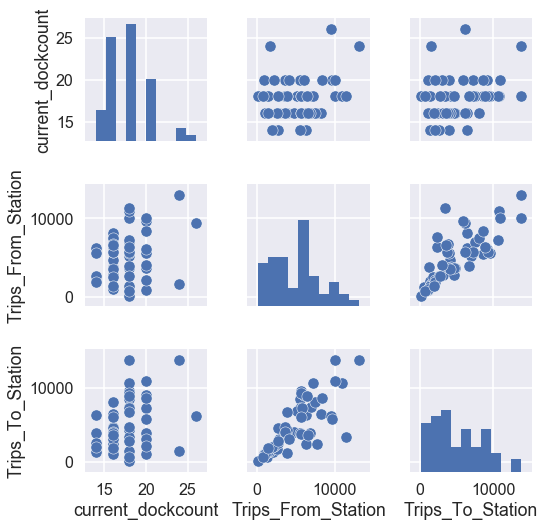

In [56]:
#Generating a pairplot to see correlation if there is any
sns.pairplot(dock_from_to)
plt.show()

#### Initial Observation
From the pairplot above we see that there is a very slight correlation between the number of trips taken from a station and the number of docks at a station, the number of trips taken to a station and the number of docks at a station. There is a much stronger relationship between the number of trips taken from a station and the number of trips taken to a station which speaks to the overall popularity of any given station.

Computing the pearson correlation coefficients and computing the p_value from their test of correlation will help us further quantify these relationships. 

#### Pearson Correlation Coefficient and P_values

I will generate 100,000 permutation replicates under the **null hypothesis** that data is not correlated to compute the p-value of the data being correlated (as much as it is) by chance.

In [34]:
from scipy import stats
import numpy as np

#Writing a function that computes the coerr_mat for 2 given arrays
def calc_pearson(x,y):
    coerr_mat = np.corrcoef(x,y)
    return coerr_mat[0,1]

In [35]:
from_dockcount = pd.merge(from_station_count,dockcount, on = 'name')
dock_count = from_dockcount['current_dockcount']
from_trips = from_dockcount['Trips_From_Station']
observed_pearson = calc_pearson(dock_count, from_trips)
print('Pearson correlation coefficient for number of docks at a station and number of trips taken from that station:')
print(observed_pearson)

#Stimulating the data under the null hypothesis
perm_reps = np.empty(100000)
for i in range(100000):
    perm_res = np.random.permutation(from_trips)
    perm_rep = calc_pearson(dock_count,perm_res)
    perm_reps[i] = perm_rep
    
p_value = np.sum(perm_reps >= observed_pearson) / len(perm_reps)
print('P-value:')
print(p_value)

Pearson correlation coefficient for number of docks at a station and number of trips taken from that station:
0.287489634451
P-value:
0.01962


In [36]:
to_dockcount = pd.merge(to_station_count,dockcount, on = 'name')
dock_count = to_dockcount['current_dockcount']
to_trips = to_dockcount['Trips_To_Station']
observed_pearson = calc_pearson(dock_count, to_trips)
print('Pearson correlation coefficient for number of docks at a station and number of trips taken to that station:')
print(observed_pearson)

#Stimulating the data under the null hypothesis
perm_reps = np.empty(100000)
for i in range(100000):
    perm_res = np.random.permutation(to_trips)
    perm_rep = calc_pearson(dock_count,perm_res)
    perm_reps[i] = perm_rep
    
p_value = np.sum(perm_reps >= observed_pearson) / len(perm_reps)
print('P-value:')
print(p_value)

Pearson correlation coefficient for number of docks at a station and number of trips taken to that station:
0.320496700678
P-value:
0.01085


In [37]:
pearson, p_val = stats.pearsonr(dock_from_to['Trips_From_Station'],dock_from_to['Trips_To_Station'])
print('Pearson correlation coefficient for number of trips to a station and number of trips taken from that station:')
print(pearson)
print('P-value:')
print(p_val)

Pearson correlation coefficient for number of trips to a station and number of trips taken from that station:
0.75048650149
P-value:
6.41276740625e-11


#### Conclusion:
 - The correlation coefficients computed supports our initial observation. There is a very small positive correlation between the number of docks at a station and the number of trips taken to and from a station. 

 - There is a relatively higher correlation betweent the trips taken to a station and the number of docks than the trips taken from a station and the number of docks, but the overall correlations is still very small

 - There is a much higher positive correlation between the trips taken from a station and the trips taken to a station which indicates that a station's overall popularity makes it a popular starting and a popular ending point for users and there is not a huge split between most station's popularity as a starting point and an ending point.
 
**The p_values computed from generating 100,000 permutation replicates indicate statistical significance and even practically we can safely assume that the data is not correlated due to chance**

### Correlation between the age of members and trip duration 

In [57]:
#Calculating the age of the members from the birthyear column 
def age_calc(n):
    return 2017 - n

member_trip_data['age'] = member_trip_data['birthyear'].apply(age_calc)
member_trip_data.head(3)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,gender,birthyear,age
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1960.0,57.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1970.0,47.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1988.0,29.0


In [59]:
#Removing outliers and computing the pearson correlation coefficient and the p-value
outlier_filter = member_trip_data['tripduration'] <= 3600
member_data = member_trip_data.loc[outlier_filter]
member_data.head()
stats.pearsonr(member_data['age'],member_data['tripduration'])

(0.10386436641030339, 0.0)

#### Conclusion: There is an extremely small positive correlation between the age of members and trip duration, whichy indicates that the older members have a very slightly higher trip duration than younger members.

### Computing the correlation between various weather factors and the number of trips taken on a given day

#### Further Procesing the Data 
Since the data for the trips taken and the weather on each day for the period of time when the data for the trips was collected is contained in two different datasets, it would require further processing the data and merging both the datasets accurately to get a  correlation between weather factors such as mean temperature, maximum temperature, mean humidity, mean wind speed and the number of trips taken on a given day <br>

For this I will convert the 'starttime' and 'date' columns of the trips dataset and weather dataset respectively to datetime objects and the merge both the datasets on these columns to get accurate observations of weather attributes and amount of trips for each day.


In [40]:
from datetime import datetime

In [41]:
#Extracting required columns from the trip_data dataset
trips = trip_data[['trip_id','starttime']]

#Writing a function that converts 'starttime' column from trip_data to datetime object
def dt_convert(s):
    try:
        dt = s[:-6]
        return datetime.strptime(dt,'%m/%d/%Y')
    except:
        dt = s[:-5]
        return datetime.strptime(dt,'%m/%d/%Y')
    
#Creating a new column 'date' from starttime by applying dt_convert()
trips['date'] = trips['starttime'].apply(dt_convert)



#Extracting required columns from the weather_data dataset
weather = weather_data[['Date','Mean_Temperature_F','Mean_Humidity','Mean_Wind_Speed_MPH','Max_Temperature_F']]

#Writing a function that converts 'Date' column from weather_data to datetime object
def dt_conv_simp(s):
    return datetime.strptime(s,'%m/%d/%Y')

#Creating a new column 'date' from starrtime by applying dt_conv_simp()
weather['date'] = weather['Date'].apply(dt_conv_simp)


/Users/sam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
#Dropping 'starttime' and 'Date' columns from trips and weather resectively
trips = trips.drop(['starttime'],axis=1)
weather = weather.drop(['Date'],axis=1)

In [43]:
#Merging trips and weather dataset on the new datetime object 'date' column
trips_weather = pd.merge(trips,weather, on='date')

In [44]:
#Grouping the dataframe to get trips per day with weather stats about each day
trips_weather_group = trips_weather.groupby(['date','Mean_Temperature_F','Mean_Humidity','Mean_Wind_Speed_MPH','Max_Temperature_F'])
trips_weather_count = trips_weather_group['trip_id'].count()
trips_weather_count = pd.DataFrame(trips_weather_count).reset_index()
trips_weather_count.columns = ['Date','Mean_Temp(F)','Mean_Humid','Mean_Wind(MPH)','Max_Temp(F)','Trip_Count']

In [45]:
#Displaying the first 5 rows of the new dataset
trips_weather_count.head(5)

,Date,Mean_Temp(F),Mean_Humid,Mean_Wind(MPH),Max_Temp(F),Trip_Count
0,2014-10-13,62.0,68,4,71,818
1,2014-10-14,59.0,78,5,63,982
2,2014-10-15,58.0,77,7,62,626
3,2014-10-16,61.0,61,4,71,790
4,2014-10-17,60.0,72,3,64,588


#### Computing the correlation matrix for the dataset to see how amount of trips change according to different weather factors

In [46]:
#Computing the cross correlation matrix for weather and number of trips taken each day
corr_mat = trips_weather_count.corr()
corr_mat

,Mean_Temp(F),Mean_Humid,Mean_Wind(MPH),Max_Temp(F),Trip_Count
Mean_Temp(F),1.000000,-0.584973,-0.018131,0.970604,0.399741
Mean_Humid,-0.584973,1.000000,0.218338,-0.673048,-0.483360
Mean_Wind(MPH),-0.018131,0.218338,1.000000,-0.100926,-0.266897
Max_Temp(F),0.970604,-0.673048,-0.100926,1.000000,0.432901
Trip_Count,0.399741,-0.483360,-0.266897,0.432901,1.000000


#### Heatmap of the correlation matrix 

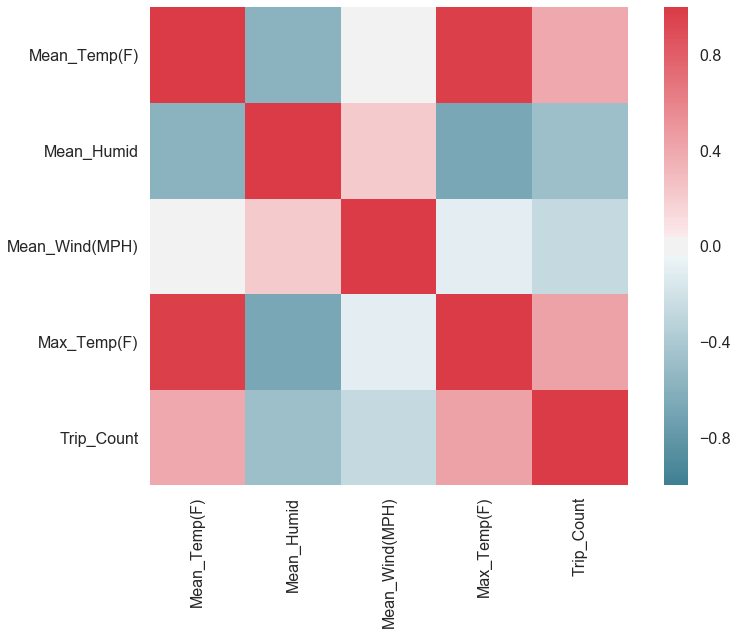

In [47]:
sns.heatmap(corr_mat,cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)
plt.show()

#### Initial Observation:
Through the correlation matrix and the heatmap we see that the **mean temperature** and the **maximum temperature** are **positively correlated** to the number of trips on a given day while the **mean humidity** and the **mean wind speed** are **negatively correlated** to the number of trips taken on a given day.

I will conduct a test of correlation by generating 100,000 permutation replicates to compute the p-value of these correlations occuring by chance.

In [48]:
#Functions that calculate the p-value of two given arrays using permutation resampling
def test_of_corr(x:'array',y:'array',obs_pears:int) -> p_value:
    perm_reps = np.empty(100000)
    
    for i in range(100000):
        perm_res = np.random.permutation(x)
        perm_rep = calc_pearson(perm_res,y)
        perm_reps[i] = perm_rep
    
    return np.sum(perm_reps >= obs_pears) / len(perm_reps)


def test_of_corr_n(x:'array',y:'array',obs_pears:int) -> p_value:
    perm_reps = np.empty(100000)
    
    for i in range(100000):
        perm_res = np.random.permutation(x)
        perm_rep = calc_pearson(perm_res,y)
        perm_reps[i] = perm_rep
    
    return np.sum(perm_reps <= obs_pears) / len(perm_reps)

#### Calculating probability value of chance for all the correlations with number of trips

In [49]:
p_value1 = test_of_corr(trips_weather_count['Trip_Count'],trips_weather_count['Mean_Temp(F)'],0.399741)
print('P_value from test of correlation for number of trips and mean temperature:')
p_value1

P_value from test of correlation for number of trips and mean temperature:


0.0

In [50]:
p_value2 = test_of_corr_n(trips_weather_count['Trip_Count'],trips_weather_count['Mean_Humid'],-0.483360)
print('P_value from test of correlation for number of trips and mean humidity:')
p_value2

P_value from test of correlation for number of trips and mean humidity:


0.0

In [51]:
p_value3 = test_of_corr_n(trips_weather_count['Trip_Count'],trips_weather_count['Mean_Wind(MPH)'],-0.266897)
print('P_value from test of correlation for number of trips and mean wind speed:')
p_value3

P_value from test of correlation for number of trips and mean wind speed:


0.0

In [52]:
p_value4 = test_of_corr(trips_weather_count['Trip_Count'],trips_weather_count['Max_Temp(F)'],0.432901)
print('P_value from test of correlation for number of trips and maximum temperature:')
p_value4

P_value from test of correlation for number of trips and maximum temperature:


0.0

#### Conclusion:
 - The p-values generated in all of the cases, were statistically significant and we can safely assume that the correlation between the weather factors and number of trips is not due to chance.
 - The mean temperature and the maximum temperetaure are positively correlated with the amount of trips taken on a given day. The positive correlation between maximum temperature and number of trips is relatively higher than the positive correlation between mean temperature and number of trips, in this case they both mean that higher temperature makes for a **favourable condition** for riding using Pronto's bikes for it's users.
 - The mean humidity and mean wind speed are negatively correlated with the amount of trips taken during a day. The mean humidity neatively affects the amount of trips taken during a day more than the mean wind speed does, but we can assume that they both make for **unfavourable conditons** for Pronto's users.